In [ ]:
# from psfsynth import *
# inst = 1
# ifield = 4-8
# filt_order = 3 (inst=1), 5(inst=2)
# run_psf_synth(inst,ifield, filt_order=filt_order)
# profdat = run_psf_combine(inst, ifield)

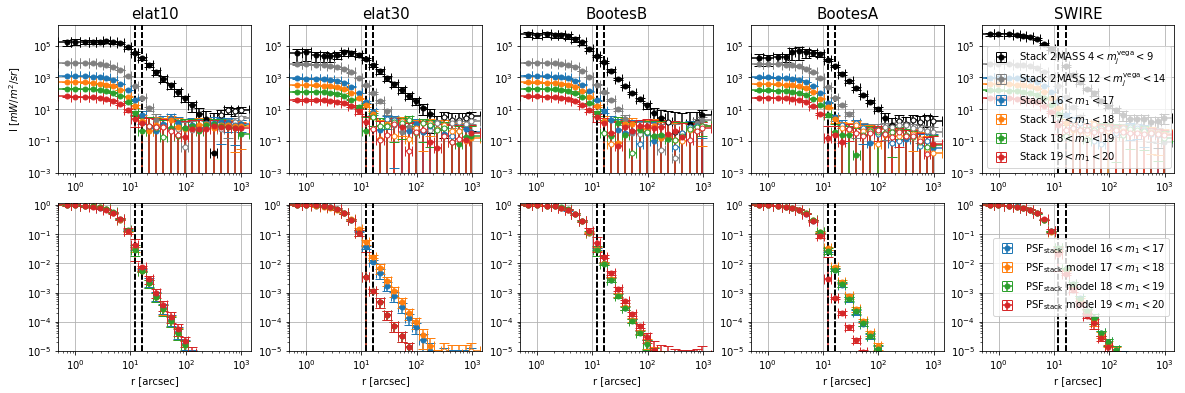

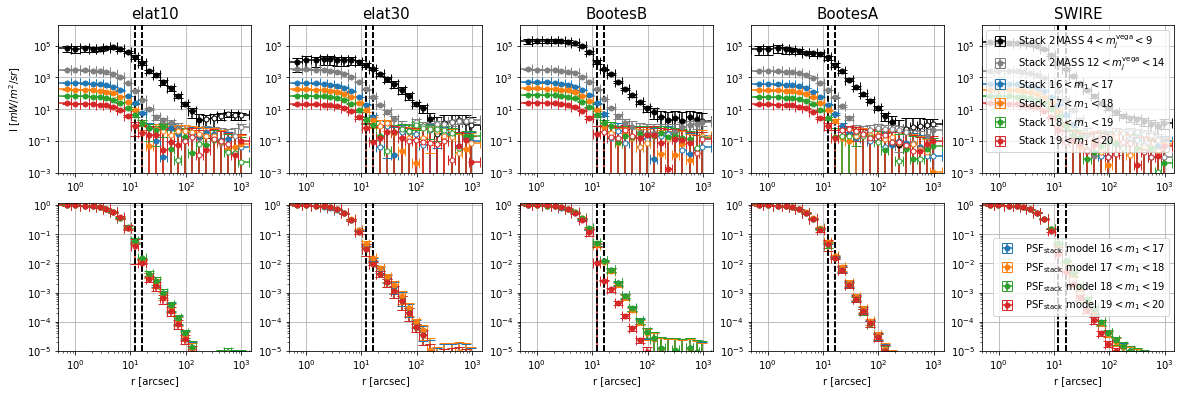

In [106]:
from psfstack import *

for inst in [1,2]:
    fig, ax = plt.subplots(2, 5, figsize = (20,6))
    for i,ifield in enumerate([4,5,6,7,8]):
        fname = mypaths['alldat'] + 'TM'+ str(inst) + \
        '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
        with open(fname, "rb") as f:
            profdat = pickle.load(f)

        plot_err_log(profdat['rbins'], 
                     profdat['out']['profcb'],
                     profdat['out']['profcb_err'],
                     ax=ax[0][i], color='k',label=r'Stack 2MASS $4 < m_j^{\rm vega} < 9$')

        plot_err_log(profdat['rbins'], 
                     profdat['mid']['profcb'],
                     profdat['mid']['profcb_err'],
                     ax=ax[0][i], color='grey',label=r'Stack 2MASS $12 < m_j^{\rm vega} < 14$')


        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            plot_err_log(profdat['rbins'], 
                         profdat[im]['profcb'],
                         profdat[im]['profcb_err'],
                         ax=ax[0][i], color='C'+str(im),label=r'Stack $%d < m_1 <%d$'%(m_min, m_max))
            plot_err_log(profdat['rbins'], 
                         profdat[im]['comb']['profcb'],
                         profdat[im]['comb']['profcb_err'],
                         ax=ax[1][i], color='C'+str(im),
                         label=r'PSF$_{\rm stack}$ model $%d < m_1 <%d$'%(m_min, m_max))

            ax[0][i].axvline(profdat['rbins'][9],c='k',ls='--')
            ax[0][i].axvline(profdat['rbins'][10],c='k',ls='--')
            ax[1][i].axvline(profdat['rbins'][9],c='k',ls='--')
            ax[1][i].axvline(profdat['rbins'][10],c='k',ls='--')

        ax[0][i].set_ylim([1e-3,2e6])
        ax[0][i].set_xlim([5e-1,1.5e3])
        ax[0][i].grid()    
        ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
        ax[1][i].set_ylim([1e-5,1.2])
        ax[1][i].set_xlim([5e-1,1.5e3])
        ax[1][i].grid() 
        ax[-1][i].set_xlabel('r [arcsec]')
    ax[0][-1].legend()
    ax[1][-1].legend()
    ax[0][0].set_ylabel('I [$mW/m^2/sr$]')

### TM1 elat30 19 < m < 20 stacking

it's not consistent with other mag bins, so use 18 < m <19 bin for this one 

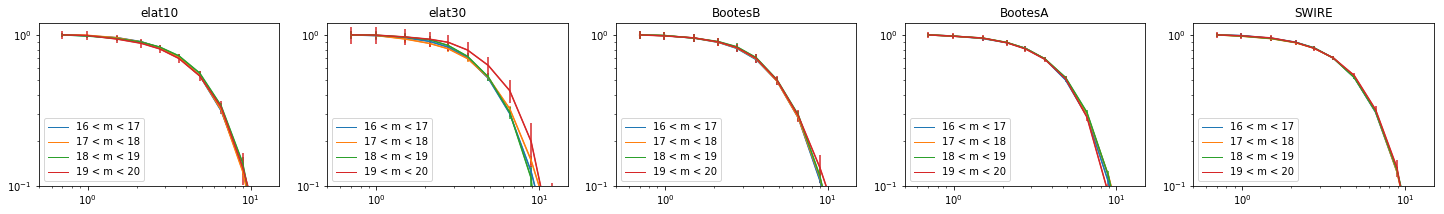

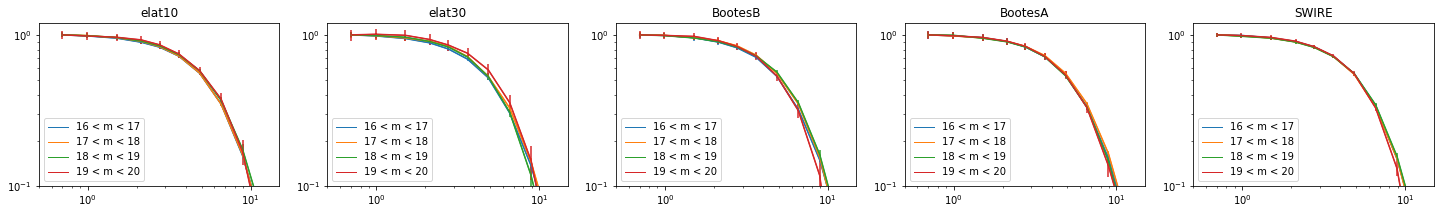

In [105]:
from psfsynth import *
for inst in [1,2]:
    fig, ax = plt.subplots(1, 5, figsize = (25,3))
    for i,ifield in enumerate([4,5,6,7,8]):
        fname = mypaths['alldat'] + 'TM'+ str(inst) + \
        '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
        with open(fname, "rb") as f:
            psfdat = pickle.load(f)

        for im in range(4):
            m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
            ax[i].loglog(psfdat['rbins'], psfdat[im]['profcb']/psfdat[im]['profcb'][0],
                       'C'+str(im), lw=1, label='%d < m < %d'%(m_min, m_max))
            ax[i].errorbar(psfdat['rbins'], psfdat[im]['profcb']/psfdat[im]['profcb'][0],
                         psfdat[im]['profcb_err']/psfdat[im]['profcb'][0], c='C'+str(im))
        ax[i].set_ylim([1e-1,1.2])
        ax[i].set_xlim([5e-1,15])
        ax[i].set_title(fieldnamedict[ifield])
        ax[i].legend()

In [13]:
inst = 1
ifield = 7
m_min = 12
m_max = 13

fname = mypaths['alldat'] + 'TM'+ str(inst) +\
 '/psfdata_synth_ps_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
with open(fname, "rb") as f:
    profdat2 = pickle.load(f)

In [1]:
from psfsynth import *
profdat1 = run_psf_synth_ps_mag(1, 7, 12, 13, savedata=True)
clear_output()

profdat = run_psf_synth_2m_mag(1, 7, 4, 8, savedata=True)
clear_output()

<ErrorbarContainer object of 3 artists>

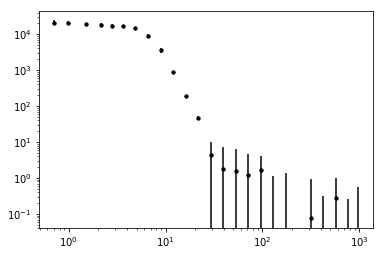

In [12]:
plt.loglog(profdat1['rbins'],profdat1['profcb'],'k.')
plt.errorbar(profdat1['rbins'],profdat1['profcb'],profdat1['profcb_err'], fmt='.',c='k')

<ErrorbarContainer object of 3 artists>

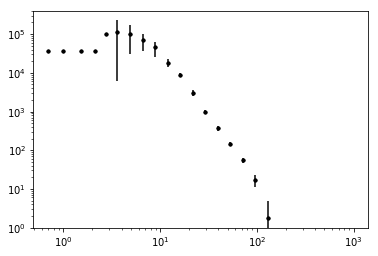

In [11]:
plt.loglog(profdat['rbins'],profdat['profcb'],'k.')
plt.errorbar(profdat['rbins'],profdat['profcb'],profdat['profcb_err'], fmt='.',c='k')